In [2]:
import pandas as pd
import numpy as np
# For panel visualizations:
import panel as pn
import param
# For displaying images:
import cv2
import glob
import os
import sys
import matplotlib
# matplotlib.use('agg')
import matplotlib.pyplot as plt
import seaborn as sns
from moviepy.editor import *
import wavio

pn.extension()


In [ ]:
if not os.path.exists('./tmp'):
    os.makedirs('./tmp')

In [3]:
labels = []

multi_label_select = pn.widgets.MultiSelect(name='Select labels to plot', value=labels, options=labels, height=100, width=500)
# input_text = pn.widgets.TextInput(name='Input video', placeholder='Input video path (abs or rel)', value='RedBalloon_clip1_excerpt.mov')
# input_text = pn.widgets.FileInput()
input_file = pn.widgets.FileSelector('.', name='Input video', value=['RedBalloon_clip1_excerpt.mov'])
output_text = pn.widgets.TextInput(name='Output video (.avi)', placeholder='Output video path (*.avi)', value='redbaloon.avi')
# annotation_text = pn.widgets.TextInput(name='Annotation file (.txt)', placeholder='Input annotation path *.txt (abs or rel)', value='')
annotation_text = pn.widgets.FileInput(accept='.txt')

sampling_rate = pn.widgets.IntSlider(name='Sampling rate (fps). Small fps helps rendering faster', 
start=1, end=30, value=3)

progress_bar = pn.indicators.Progress(name='Progress', width=200, value=0)


In [4]:
@pn.depends(input_file.param.value)
def update_sampling_rate(input_file):
    cv2_reader = cv2.VideoCapture(input_file[0])
    fps = cv2_reader.get(cv2.CAP_PROP_FPS)
    sampling_rate.value = int(np.ceil(fps / 2))

In [5]:
# number of axes of a matplotlib figure is assigned to draw the frame (image)
image_row = 4
# aspect ratio of matplotlib figure
width = 1920
height = 160
w_h_ratio = round(width / height)

row_count = pn.widgets.Select(name='Grid Row', value=image_row, options=list(range(image_row, 20)))
column_count = pn.widgets.Select(name='Grid Column', value=1, options=list(range(1, 20)))

@pn.depends(column_count, multi_label_select)
def update_row(column_count, multi_label_select):
    count = len(multi_label_select) + image_row
    row = row_count.value
    while row * column_count < count:
        row += 1
    while (row - 1) * column_count >= count and row - 1 >= image_row:
        row -= 1

    row_count.value = row

In [6]:
# fig, ax = plt.subplots()
# pn.pane.PNG('tmp.png')

In [7]:
# if not os.path.exists('./tmp'):
#     os.makedirs('./tmp')

# # preview = pn.widgets.MultiSelect(options=['preview.png'], value=['preview.png'])
# preview_button = pn.widgets.Button(name='Render a Preview', button_type='primary')

# @pn.depends(preview_button)
# def preview_img(preview):
#     print('Update Preview')
#     # print(type(preview))
#     # print(preview)
#     return pn.pane.PNG(f'{preview[0]}', width=900 * column_count.value, height=300 * row_count.value)

In [8]:
class ActionExample(param.Parameterized):

    
    import_annotation = param.Action(lambda x: x.param.trigger('import_annotation'), label='Import Annotation')

    @param.depends('import_annotation')
    def import_anno(self):
        try:
            print(f"Loading annotation file={annotation_text.filename}")
            with open(f'{annotation_text.filename}', 'rt') as f:
                annotation = [x.strip() for x in f.readlines()]
                annotation = [x.split(' ') for x in annotation]
            labels = [x[0] for x in annotation]
            multi_label_select.options = labels
            annotation = [pd.Series(data=x[1:], name=x[0], dtype=float) for x in annotation]
            self.annotation = annotation

#             fig = plt.figure()
#             plt.axis([0, 10, 0, 10])
            t = f'Successfully loaded {annotation_text.filename}'
            print(f"Loaded annotation file={annotation_text.filename}")
#             plt.text(5, 10, t, fontsize=18, style='oblique', ha='center',
#                      va='top', wrap=True)
            return pn.Row(f'## {t}')
        except Exception as e:
#             fig = plt.figure()
#             plt.axis([0, 10, 0, 10])
            t = str(e)
            # print(f"{t}")
#             plt.text(5, 10, t, fontsize=18, style='oblique', ha='center',
#                      va='top', wrap=True)
            return pn.Row(f'## {e}')

    def process_frame(self, frame_id, frame):
        # progress_bar.value = int(frame_id / cv2_reader.get(cv2.CAP_PROP_FRAME_COUNT))
        print(f'Processing frame {frame_id}...')

        row = row_count.value
        col = column_count.value
        while row * col < len(multi_label_select.value) + image_row:
            row += 1

        fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(w_h_ratio * col, 1 * row), squeeze=False,
        sharex=True)

        # iterate through selected column and draw, annotation dependent processing:
        count = image_row
        for series in self.annotation:
            for label in list(multi_label_select.value):
                if series.name == label:
                    for t in series:
                        axes[count % row, count // row].axvline(t, linewidth=2, alpha=0.5, c='b')
                    axes[count % row, count // row].axvline(frame_id / self.fps, linewidth=2, alpha=0.5, c='r')
                    axes[count % row, count // row].set_title(label, x=-0.08, y=0.4, size=18)
                    axes[count % row, count // row].set_axis_off()
                    axes[count % row, count // row].set_xlim(left=0, right=self.num_frames / self.fps)
                    count += 1
                    
        for i in range(count, row * col):
            # axes[i % row, i // row].set_visible(False)
            axes[i % row, i // row].axis('off')
        # doesn't get removed when saving with tight bbox, but set_visible=False gets removed
        for i in range(image_row):
            axes[i, 0].axis('off')
        # axes[0, 0].set_visible(False)
        # axes[0, 0].spines["right"].set_visible(False)
        # axes[0, 0].spines["left"].set_visible(False)
        # axes[0, 0].spines["bottom"].set_visible(False)
        # axes[0, 0].spines["top"].set_visible(False)

        tmp_path = f'./tmp/tmp_{np.random.randint(100)}.png'
        # plt.axis('off')
        plt.savefig(tmp_path, bbox_inches='tight', pad_inches = 0)
        # plt.savefig(tmp_path)
        img = cv2.imread(tmp_path)
        img = cv2.resize(img, dsize=(width * col, height * row))
        # print(img.shape, frame.shape)
        scale = min(width / frame.shape[1], height * image_row / frame.shape[0])
        # print(scale)
        frame = cv2.resize(frame, dsize=(int(scale * frame.shape[1]), int(scale * frame.shape[0])))
        # print(frame.shape)
        w_pad = int((width - frame.shape[1]) // 2)
        h_pad = int((height * image_row - frame.shape[0]) // 2)
        # print(w_pad, h_pad)
        img[h_pad: h_pad + frame.shape[0], w_pad: w_pad + frame.shape[1], :] = frame

        return img

    def process_audio(self, last_frame_id, audio_sampling_rate):
        audio_frames = np.zeros(shape=(int(self.num_frames / self.fps * audio_sampling_rate)))
        frequencies = np.arange(600, 6000, 400)
        count = image_row
        frequencies = np.arange(600, 6000, 400)
        for series in self.annotation:
            for label in list(multi_label_select.value):
                if series.name == label:
                    for t in series:
                        # print(f'Adding {series.name} at frame {frame_id} for annotated {t * fps}')
                        f = frequencies[count]
                        sample = 500
                        x = np.arange(sample)
                        y = np.sin(2 * np.pi * f * x / audio_sampling_rate)
                        start = max(int(t * audio_sampling_rate - len(y) / 2), 0)
                        audio_frames[start: start + len(y)] = y
                        # audio_frames[start: start + len(y)] = audio_frames[start: start + len(y)] + y
                    count += 1
        
        audio_frames = audio_frames[:int(last_frame_id / self.fps * audio_sampling_rate)]
        return audio_frames

    draw_video = param.Action(lambda x: x.param.trigger('draw_video'), label='Draw')

    @param.depends('draw_video')
    def matrix_visualize(self):
        # define reader and writer
        try:
            cv2_writer = None
            # cv2_reader = cv2.VideoCapture(input_text.value)
            cv2_reader = cv2.VideoCapture(input_file.value[0])
            self.fps = cv2_reader.get(cv2.CAP_PROP_FPS)
            self.num_frames = int(cv2_reader.get(cv2.CAP_PROP_FRAME_COUNT))

            length_row = len(self.annotation)

            frame_id = -1
            while cv2_reader.isOpened():
                ret, frame = cv2_reader.read()
                frame_id += 1
                # if frame_id > 200:
                #     break
                if not ret:
                    break
                if frame_id % int(round(self.fps / sampling_rate.value)) != 0:
                    continue
                    
                img = self.process_frame(frame_id, frame=frame)
                if cv2_writer is None:
                    fourcc = cv2.VideoWriter_fourcc(*'XVID')
                    cv2_writer = cv2.VideoWriter(output_text.value, fourcc=fourcc, fps=sampling_rate.value,
                                                 frameSize=(img.shape[1], img.shape[0]),
                                                 isColor=True)
                cv2_writer.write(img)
                plt.close('all')
                # plt.clf()
            cv2_writer.release()
            cv2_reader.release()
            print(f'Done rendering video at {output_text.value}')
            
            audio_sampling_rate = 44100
            audio_frames = self.process_audio(last_frame_id=frame_id, audio_sampling_rate=audio_sampling_rate)
            audio_path = os.path.splitext(output_text.value)[0] + '.wav'
            wavio.write(f"{audio_path}", audio_frames, audio_sampling_rate, sampwidth=3)
            print(f'Done rendering audio at {audio_path}')

            clip = VideoFileClip(f"{output_text.value}")
            audioclip = AudioFileClip(f"{audio_path}")
            videoclip = clip.set_audio(audioclip)
            videoclip.write_videofile(f"{os.path.splitext(output_text.value)[0]}.mp4")
            print(f'Done rendering audio video at {os.path.splitext(output_text.value)[0]}.mp4')

            t = f'Done rendering audio video at {os.path.splitext(output_text.value)[0]}.mp4'
            return pn.Row(f'## Status of rendering full video \n{t}')
        except Exception as e:
            t = str(e)
            return pn.Row(f'## Status of rendering full video \n{e}')


    preview_button = param.Action(lambda x: x.param.trigger('preview_button'), label='Render Preview')
    @param.depends('preview_button')
    def render_preview(self):
        # define reader and writer
        try:
            cv2_reader = cv2.VideoCapture(input_file.value[0])
            self.fps = cv2_reader.get(cv2.CAP_PROP_FPS)
            self.num_frames = int(cv2_reader.get(cv2.CAP_PROP_FRAME_COUNT))
            frame_id = -1

            length_row = len(self.annotation)

            while cv2_reader.isOpened():
                ret, frame = cv2_reader.read()
                frame_id += 1

                img = self.process_frame(frame_id=frame_id, frame=frame)
                
                img_path = './tmp/' + f"{output_text.value.split('.')[0]}_{np.random.randint(100)}.png"
                cv2.imwrite(img_path, img)
                plt.close('all')
                break
            cv2_reader.release()

            t = f"Done rendering frame {frame_id}"
            return pn.Column(f'## Status of Rendering \n{t}', pn.pane.PNG(f'{img_path}', width=img.shape[1] // 2, height=img.shape[0] // 2))
        except Exception as e:
            t = str(e)
            return pn.Column(f'## Status of Rendering \n{e}', pn.pane.PNG(f'preview.png', width=960, height=640))


action_video = ActionExample()

Loading annotation file=None


Column
    [0] Column
        [0] Markdown(str)
        [1] FileInput(accept='.txt')
    [1] Row
        [0] Button(name='Import Annotation')
    [2] Row
        [0] ParamMethod(method)
    [3] Row
        [0] MultiSelect(height=100, name='Select labels to plot', sizing_mode='fixed', width=500)
        [1] Column
            [0] Select(name='Grid Column', options=[1, 2, 3, 4, 5, ...], value=1)
            [1] ParamFunction(function)
    [4] Column
        [0] FileSelector(name='Input video', value=['RedBalloon_clip1_excerpt...])
        [1] TextInput(name='Output video (.avi)', placeholder='Output video p..., value='overlay2.avi')
    [5] Row
        [0] Markdown(str)
    [6] Column
        [0] Button(name='Render Preview')
        [1] ParamMethod(method)
    [7] Row
        [0] Markdown(str)
    [8] Row
        [0] ParamFunction(function)
        [1] IntSlider(end=30, name='Sampling rate (..., start=1, value=29)
    [9] Row
        [0] Button(name='Draw')
    [10] Row
        [0] ParamMethod(method)
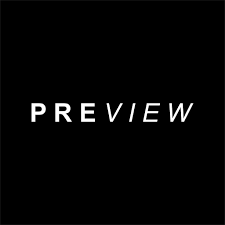

In [78]:
dashboard = pn.Column(
    pn.Column('Annotation file (.txt)', annotation_text),
    pn.Row(action_video.param.import_annotation),
    pn.Row(action_video.import_anno),
    pn.Row(multi_label_select, pn.Column(column_count, update_row, 
    # pn.Column(f"Inferred #rows (don't need to specify", row_count)
    )),
    pn.Column(input_file, output_text),
    pn.Row('### Preview from video'),
    pn.Column(action_video.param.preview_button, action_video.render_preview),
    pn.Row('### Draw full video'),
    pn.Row(update_sampling_rate, sampling_rate),
    pn.panel(action_video.param.draw_video),
    # pn.panel(progress_bar),
    pn.panel(action_video.matrix_visualize),
)

# Launch the dashboard
dashboard.servable()


In [70]:
action_video.annotation

AttributeError: 'ActionExample' object has no attribute 'annotation'

In [60]:
# annotation_text.filename = 'RedBalloon_clip1_exp59_trimmed_shifted_seconds.txt'
# action_video.import_anno()
# multi_label_select.value = multi_label_select.options
# column_count.value = 1
# action_video.render_preview()

Loading annotation file=RedBalloon_clip1_exp59_trimmed_shifted_seconds.txt
Loaded annotation file=RedBalloon_clip1_exp59_trimmed_shifted_seconds.txt
Processing frame 0...
Processing frame 30...
Processing frame 60...
Processing frame 90...
Processing frame 120...
Processing frame 150...
Processing frame 180...


KeyboardInterrupt: 

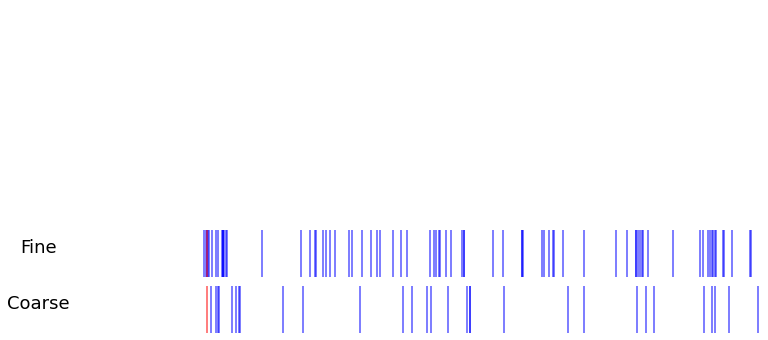

In [10]:
annotation_text.filename = 'RedBalloon_clip1_exp59_trimmed_shifted_seconds.txt'
action_video.import_anno()
sampling_rate.value = 1
multi_label_select.value = multi_label_select.options
column_count.value = 1
action_video.matrix_visualize()

In [ ]:
# audio_path = os.path.splitext(output_text.value)[0] + '.wav'
# print(f"{output_text.value}", audio_path, f"{os.path.splitext(output_text.value)[0]}.mp4")
# clip = VideoFileClip(f"{output_text.value}")
# audioclip = AudioFileClip(f"{audio_path}")
# videoclip = clip.set_audio(audioclip)
# videoclip.write_videofile(f"{os.path.splitext(output_text.value)[0]}.mp4")

In [ ]:
# import moviepy
# moviepy.__version__

In [ ]:
# fig, axes = plt.subplots(2, 1, sharey=True)
# for a in axes:
#     # a.get_xaxis().set_visible(False)
#     # a.get_yaxis().set_visible(False)
#     a.set_title('coarse', x=-0.05, y=0.2, size=18, rotation=90)
#     # a.set_axis_off()
# # fig.axes('off')
# fig.savefig('test1.png', bbox_inches='tight',pad_inches = 0)
# fig.savefig('test.png', bbox_inches='tight',pad_inches = 0)

In [ ]:
# import time
# for i in range(10):
#     time.sleep(0.1)
#     progress_bar.value = i
# pn.Row(progress_bar).servable()
